<img src="images/hospital_revolving_door.jpg" width="400" />

# Predicting Hospital Readmission using NLP
Now that doctor's notes are stored in electronic health records, natural language processing can be used for predictive modeling to improve the quality of healthcare. In this project, I build a machine learning model to predict **30-day unplanned** hospital re-admission using clinical notes.

Andrew Long's [project](https://towardsdatascience.com/introduction-to-clinical-natural-language-processing-predicting-hospital-readmission-with-1736d52bc709) served as the basis for my project, however, in part 2 of my work I will take it a step further by applying Deep Learning to see if that will improve results. Long's project was originally inspired by this ArXiv [paper](https://arxiv.org/pdf/1801.07860.pdf) by Alvin Rajkomar et al.

## Introduction
Both me and Andrew Long used conventional machine learning models to predict unplanned, 30-day hospital readmissions. My approach **outperformed** the results from Andrew Long's [project](https://towardsdatascience.com/introduction-to-clinical-natural-language-processing-predicting-hospital-readmission-with-1736d52bc709) by **13% (AUC)**.

As a quick recap, here's a list of additional things that I did differently:
* Concatenate all the notes (instead of only using the last discharge summary)
* Removed all English stopwords via NLTK
* Performed lemmatization
* Counted readmission only once

In part 2 of this project I will apply a Deep Learning transformer model to see if that will further improve my outcome!

# Intended Audience
This projects is intended for people who are interested in Machine Learning in Healthcare. 

# What's in This Notebook
In this notebook I will:
* Preprocess the unstructured notes
* Build a predictive model
* Assess the quality of my models
* Ideate on potential future areas of improvement

# Why is This Important?
This topic is important because readmissions are viewed as a standard measure of quality of care for healthcare providers.
It's anticipated that using predictive modeling with Electronic Health Record (EHR) will drive improve healthcare quality [[Source](https://arxiv.org/pdf/1801.07860.pdf)]. In fact, a "_recent Yale School of Medicine study found that hospitals financially penalized under the Hospital Readmission Reduction Program...reduced their readmission rates at a higher rate than nonpenalized hospitals"._[[Source](https://yaledailynews.com/blog/2017/01/17/medicare-penalties-lead-to-decline-in-hospital-readmission-rates/)]

# Model Definition
In this project, I build a machine learning model to predict 30-day unplanned hospital readmission using discharge summaries.

**Definitions**:
1. A hospitalization is considered a "re-admission" if its admission date was within 30 days after discharge of a hospitalization. 
2. A readmission can only be counted once.

# About the Dataset
I will utilize the MIMIC-III (Medical Information Mart for Intensive Care III), an amazing free hospital database. 

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge).


MIMIC-III is an open-access relational database containing tables of data relating to patients who stayed within the intensive care units (ICU) at Beth Israel Deaconess Medical Center. This public database of Electronic Health Records contains data points on about 41,000 patients from intensive care units between 2001 and 2012, including notes on close to 53,000 admissions.

Due to the sensitive nature of medical data, I cannot include the data openly in this repository. If you'd like to get access to the data for this project, you will need to request access at this link (https://mimic.physionet.org/gettingstarted/access/).

In this project, I will make use of the following MIMIC tables:
* **[ADMISSIONS](https://mimic.physionet.org/mimictables/admissions/)** &mdash; a table containing admission and discharge dates. It has a unique identifier HADM_ID for each admission. HADM_ID refers to a unique admission to the hospital.
* **[NOTEEVENTS](https://mimic.physionet.org/mimictables/noteevents/)** &mdash; discharge summaries, which condense information about a patient’s stay into a single document (linked by the HADM_ID). There are a total of 2,083,180 rows in this table.

# Step 1. Prepare the Data
I will follow the steps below to prep the data from the ADMISSIONS and NOTEEVENTS MIMIC tables for my machine learning project.

<img src="images/preparing_data2.png" width="600" />

## Load `ADMISSIONS` Table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_adm = pd.read_csv('ADMISSIONS.csv')

## Explore the data
It's important to always spend time exploring the data.

In [ ]:
df_adm.head()

In [3]:
df_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

The main columns of interest in this table are:
* `SUBJECT_ID` &mdash; unique identifier for each subject
* `HADM_ID` &mdash; unique identifier for each hospitalization
* `ADMITTIME` &mdash; admission date with format YYYY-MM-DD hh:mm:ss
* `DISCHTIME` &mdash; discharge date with same format
* `DEATHTIME` &mdash; death time (if it exists) with same format
* `ADMISSION_TYPE` &mdash; includes ELECTIVE, EMERGENCY, NEWBORN, URGENT

Let's look at the data type of each column

In [ ]:
df_adm.dtypes

Let's see what's in the `ADMISSION_TYPE` column

In [5]:
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

## Remove NEWBORN admissions
According to the MIMIC [site](https://mimic.physionet.org/mimictables/admissions/) "Newborn indicates that the HADM_ID pertains to the patient's birth." 

I will remove all NEWBORN admission types because in this project I'm not interested in studying births &mdash; my primary interest is EMERGENCY and URGENT admissions.

In [6]:
df_adm = df_adm.loc[df_adm.ADMISSION_TYPE != 'NEWBORN']

In [7]:
# Ensure rows with NEWBORN ADMISSION_TYPE are removed
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
URGENT        1336
dtype: int64

## Remove Deaths
I will remove all admissions that have a DEATHTIME because this in project I'm studying re-admissions, not mortality. And a patient who died cannot be re-admitted.

In [ ]:
# Before removing deaths, first store the hadm_ids for dead patients. It will be used later to also remove deaths from the notes table
hadm_rows_death = df_adm.loc[df_adm.DEATHTIME.notnull()]
print("Number of death admissions:", len(hadm_rows_death))

# Store HADM_ID for dead patients in a list
hadm_death_list = hadm_rows_death["HADM_ID"].tolist()
print("Length of the HADM_ID list:", len(hadm_death_list))

In [ ]:
# remove admissions of patients who died
df_adm = df_adm.loc[df_adm.DEATHTIME.isnull()]
df_adm

In [ ]:
# Ensure rows with DEATHTIME are removed
print('Total rows in admissions dataframe:', len(df_adm))
print('Non-death admissions:', df_adm.DEATHTIME.isnull().sum())

The two numbers match, which is great because that means that all death admissions were removed successfully.

##  Convert strings to dates
According to the MIMIC [website](https://alpha.physionet.org/content/mimiciii/1.4/): 
> _"...dates were shifted into the future by a random offset for each individual patient in a consistent manner to preserve intervals, resulting in stays which occur sometime between the years 2100 and 2200. Time of day, day of the week, and approximate seasonality were conserved during date shifting. Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years."_

When converting dates, it is safer to use a datetime format. Setting the `errors = 'coerce'` flag allows for missing dates but it sets it to `NaT` (not a datetime) when the string doesn't match the format. For references on formats see http://strftime.org/. 

In [11]:
# Convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# Check to see if there are any missing dates
print('Number of missing admissions dates:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing discharge dates:', df_adm.DISCHTIME.isnull().sum())

Number of missing admissions dates: 0
Number of missing discharge dates: 0


Let's explore the data types again to ensure they are now `datetime`, and not `object` as before.

In [12]:
print(df_adm.ADMITTIME.dtypes)
print(df_adm.DISCHTIME.dtypes)
print(df_adm.DEATHTIME.dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]


## Get the next Unplanned admission date for each patient (if it exists)
I need to get the next admission date, if it exists. 

First I'll verify that the dates are in order. 

Then I'll use the `shift()` function to get the next admission date.

In [ ]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# When we reset the index, the old index is added as a column, and a new sequential index is used. Use the 'drop' parameter to avoid the old index being added as a column
df_adm = df_adm.reset_index(drop = True)
df_adm

In [ ]:
# Preview to verify that it did what I intended
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

You can use the `groupby` and `shift` operator to get the next admission (if it exists) for each SUBJECT_ID

In [15]:
# Create a column and put the 'next admission date' for each subject using groupby. You have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

# Same as above. Create a column that holds the 'next admission type' for each subject
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# Preview to verify that it did what I intended
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

Note that the last admission doesn’t have a next admission.

Since I want to predict **unplanned** re-admissions I will drop (filter out) any future admissions that are **ELECTIVE** so that only EMERGENCY re-admissions are measured. 

In [17]:
# For rows with 'elective' admissions, replace it with NaT and NaN
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# Preview to verify that it did what I intended
df_adm.loc[df_adm.SUBJECT_ID == 124, ['SUBJECT_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'NEXT_ADMITTIME', 'NEXT_ADMISSION_TYPE']]

Backfill in the values that I removed. So copy the `ADMITTIME` from the last emergency and paste it in the `NEXT_ADMITTIME` for the **previous** emergency. So I am effectively ignoring/skipping the ELECTIVE admission row completely. Doing this will allow me to calculate the days until the next admission. 

In [19]:
# Sort by subject_id and admission date
# It's safer to sort right before the fill incase something I did above changed the order
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# Back fill. This will take a little while.
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
# Preview
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

## Calculate days until next admission
First, let's preview the discharge dates in the table.

In [ ]:
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','DISCHTIME','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

Now let's calculate the **days** between discharge and the next emergency visit

In [22]:
df_adm['DAYS_TIL_NEXT_ADMIT'] = (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60) 

Let's preview the `DAYS_TIL_NEXT_ADMIT` column that I just created.

In [ ]:
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','DISCHTIME','NEXT_ADMITTIME', 'DAYS_TIL_NEXT_ADMIT']]

Let's do a quick manual sanity check on the first row. The approximate number of days between the DISCHTIME and the NEXT_ADMITTIME on the top row is ~520 days. So far things are looking good.

Count the total number of hospitalizations in the dataset. Remember that the `HADM_ID` refers to a unique admission to the hospital.

In [24]:
df_adm['HADM_ID'].count()

45321

There are 45,321 total hospitalizations (after removing newborns).

Now I'll count the total number of re-admissions in the dataset. This includes EMERGENCY and URGENT re-admissions because according to the MIMIC [website](https://mimic.physionet.org/mimictables/admissions/) _"Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies."_

In [25]:
df_adm['NEXT_ADMISSION_TYPE'].value_counts()

EMERGENCY    9561
URGENT        144
Name: NEXT_ADMISSION_TYPE, dtype: int64

In [26]:
df_adm['NEXT_ADMISSION_TYPE'].count()

9705

There are 9705 total re-admissions.

This only works for non-null values and as we can see below there are 35,616 null values, so I will have to filter out the null values. 

In [27]:
pd.isnull(df_adm.DAYS_TIL_NEXT_ADMIT).value_counts()

True     35616
False     9705
Name: DAYS_TIL_NEXT_ADMIT, dtype: int64

In the dataset there are 45,321 hospitalizations with 9,705 re-admissions. For those with re-admissions I can plot the histogram of days between admissions.

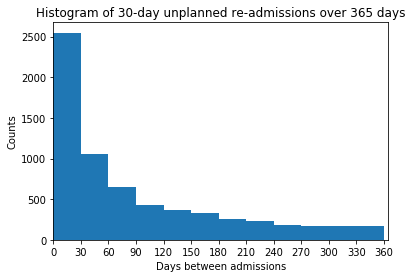

In [28]:
plt.hist(df_adm.loc[~df_adm.DAYS_TIL_NEXT_ADMIT.isnull(),'DAYS_TIL_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.xticks(np.arange(0, 365, 30))
plt.title('Histogram of 30-day unplanned re-admissions over 365 days')
plt.show()

# Load `NOTEEVENTS` Table
Now I'm ready to work with the NOTEEVENTS table.

In [29]:
df_notes = pd.read_csv("NOTEEVENTS.csv")

/Users/nwams/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The Warning above happens because column 4 (`HADM_ID`) has some integers and some missing values (NaN). Therefore I cannot use the `dtype={'HADM_ID': 'int64'}` to force it to read as all integers. In this case, Pandas default behavior is to read it as floats.

## I'll spend some time exploring the data.

In [ ]:
# Look at the first 5 rows
df_notes.head()

In [31]:
print('Number of notes:', len(df_notes))

Number of notes: 2083180


There are 2,083,180 notes. The number of notes is much higher than the number of hospitalizations (45,321) because there can be multiple notes per hospitalization. 

In [32]:
df_notes.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

The main columns of interest from the [NOTEEVENTS](https://mimic.physionet.org/mimictables/noteevents/) table are: 
* SUBJECT_ID
* HADM_ID
* CHARTDATE &mdash; records the date at which the note was charted. CHARTDATE will always have a time value of 00:00:00.
* CATEGORY &mdash; defines the type of note recorded.
* TEXT &mdash; contains the note text.

In [33]:
df_notes.HADM_ID.isnull().sum()

231836

There are 231,836 null `HADM_ID` values. This means that over 11% of the notes are missing unique hospitalization identifiers (HADM_IDs). This seems like it could be problematic so I'll investigate what might be causing this.

Let's see if any `CHARTDATE` values are missing. 

In [34]:
df_notes.CHARTDATE.isnull().sum()

0

Great, all records have a `CHARTDATE`.

Let's see if any `TEXT` values are missing.

In [35]:
df_notes.TEXT.isnull().sum()

0

Great, all records have `TEXT` values.

Let's see what type of information is in the CATEGORY column.

In [ ]:
df_notes['CATEGORY'].value_counts()

The `CATEGORY` column contains Nursing/other, Radiology, Nursing, ECG, Physician, Discharge summary, Echo, Respiratory, Nutrition, General, Rehab Services, Social Work, Case Management, Pharmacy and Consult.

Let's look at the contents of the first note from the `TEXT` column.

In [ ]:
df_notes.TEXT.iloc[0]

Due to data privacy agreements I can't show the contents of the individual notes, but I will just describe them. In the notes, the dates and any _Protected Health Information_ like name, doctor and location have been converted for confidentiality. There are also newline characters `\n`, numbers and punctuation.

### Investigate Why HADM_ID's are missing
Before going any further, I need to figure out why approx. 11% of the notes are missing.

I found an **important** discovery on the MIMIC [site](https://mimic.physionet.org/mimictables/noteevents/):
* If a patient is an **outpatient**, there will not be an HADM_ID associated with the note. 
    * An outpatient is a patient who receives medical treatment without being admitted to a hospital


* If the patient is an **inpatient**, but was not admitted to the ICU for that particular hospital admission, then there will not be an HADM_ID associated with the note.
    * An inpatient is a patient who stays in a hospital while under treatment.

This explains why some HADM_IDs are missing. Let's move on.

## Remove notes for death admissions
Before I concatenate notes for each patient, I need to remove the death admission notes as well. So that notes for dead patients don't influence my model later. Remember that earlier I removed deaths from the `df_adm` dataframe so now I'll something similar for `df_notes`.

In [ ]:
df_notes = df_notes[~df_notes['HADM_ID'].isin(hadm_death_list)]
df_notes

In [39]:
print('Number of notes after deaths were removed:', len(df_notes))

Number of notes after deaths were removed: 1841968


## Concatenate Notes for Each Patient

Since there are multiple notes per hospitalization, I will decide to concatenate **all** of the notes that belong to a patient. An alternative approach would be to use just the discharge summary, however I wanted to give the Deep Learning algorithm a full taste of the data. This will give the Neural Network the opportunity to extract insights about which features are relevant.

When concatenating the notes, I want to maintain chronological order. To determine the order I'll use the `CHARTDATE` column along with `CHARTTIME`, if it's available, because some `CHARTTIME` entries have missing (`null`) values according to the MIMIC [site](https://mimic.physionet.org/mimictables/noteevents/).

Convert the dates to datetime format.

In [40]:
# Convert CHARTDATE from string to a datetime format
df_notes.CHARTDATE = pd.to_datetime(df_notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')

# Convert CHARTTIME to datetime format
df_notes.CHARTTIME = pd.to_datetime(df_notes.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [41]:
# Ensure it did what I intended
print(df_notes.CHARTDATE.dtypes)
print(df_notes.CHARTTIME.dtypes)

datetime64[ns]
datetime64[ns]


Now that the dates were converted successfully, now I can sort each patient's notes in order of the date that it was entered. If the dates happen to be the same I will order it by whichever comes first in the table.

In [42]:
# Sort by subject_ID, CHARTDATE then CHARTTIME
df_notes = df_notes.sort_values(['SUBJECT_ID','CHARTDATE', 'CHARTTIME'])
df_notes = df_notes.reset_index(drop = True)

In [ ]:
# Preview to ensure it did what I intended
df_notes[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'TEXT']]

It looks good, so I'll keep going. 

In [ ]:
# Inspect
df_notes[['SUBJECT_ID', 'HADM_ID', 'TEXT']].head(10)

Everything looks good, as expected.

Create a new dataframe that contains the columns: `SUBJECT_ID`, and all concatenated notes for each patient. I am basically squashing all notes down to one `SUBJECT_ID`.

In [49]:
# Copy over two columns to new dataframe
df_subj_concat_notes = df_notes[['SUBJECT_ID', 'TEXT']].copy()

In [ ]:
df_subj_concat_notes.head()

Concatenate notes that belong to the same SUBJECT_ID and compress the SUBJECT_ID. Special thanks to this great Stack Overflow [answer](https://stackoverflow.com/questions/53781634/aggregation-in-pandas) on performing string aggregation.

In [51]:
df_subj_concat_notes = df_subj_concat_notes.groupby('SUBJECT_ID')['TEXT'].agg(' '.join).reset_index()

In [ ]:
# Rename the column in new dataframe to TEXT_CONCAT
df_subj_concat_notes.rename(columns={"TEXT":"TEXT_CONCAT"}, inplace=True)
df_subj_concat_notes.head()

Check one cell to ensure you see combined notes.

In [ ]:
df_subj_concat_notes.TEXT_CONCAT.iloc[0]

Since the next step is to merge the notes with the admissions table, let's double check that every `SUBJECT_ID` is unique (no duplicates). I can check this with an assert statement.

In [54]:
assert df_subj_concat_notes.duplicated(['SUBJECT_ID']).sum() == 0, 'Dulpicate SUBJECT_IDs exist'

No errors, let's keep going. 

Check if there are missing `TEXT` fields.

In [55]:
print('Number of missing TEXT fields:', df_subj_concat_notes.TEXT_CONCAT.isnull().sum())

Number of missing TEXT fields: 0


**Remember:** earlier I removed Newborns from the admission's table. I need to also remove Newborn remnants from this table as well to ensure they are not considered. But if there was any trace of newborns left, it would automatically take care of itself when I left-merge the two tables together. The same is true for deaths, the merge should automatically handle this as well.

# Merge Datasets
Now I'm ready to merge the admissions and concatenated notes tables. I use a left merge. There are a lot of cases where you get multiple rows after a merge (although we dealt with it above), it's a good idea to be extra careful and add assert statements after a merge.

In [56]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_TIL_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_subj_concat_notes, 
                        on = ['SUBJECT_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

In [ ]:
df_adm_notes

In [ ]:
df_adm_notes.loc[df_adm_notes.SUBJECT_ID == 124]

Looks like the merge went as expected. You'll notice that in the `df_adm_notes` table that even though there cases with duplicate `SUBJECT_ID`s each duplicate `SUBJECT_ID` still contains identical notes. This is almost how I want it but not quite.

Instead of identical notes for duplicate `SUBJECT_ID`s I'd like to only keep one note per `SUBJECT_ID` (so that when I apply Bag-of-Words later the words counts will be correct/not duplicated). 

Check how many admissions don't have notes:

In [59]:
df_adm_notes.TEXT_CONCAT.isnull().sum()

49

49 admissions don't have notes.

In [60]:
perc_missing_notes = (df_adm_notes.TEXT_CONCAT.isnull().sum() / len(df_adm_notes))*100
print("Only {:.2f}% of the admissions are missing.".format(perc_missing_notes))

Only 0.11% of the admissions are missing.


I could do more digging but since this is less than 1% let's move forward.

# Make Output Label

For this problem, we are going to classify if a patient will be admitted in the next 30 days. Therefore, we need to create a variable with the output label (1 = readmitted, 0 = not readmitted).

Now I'll create a column in the dataframe called `OUTPUT_LABEL` that holds the predictions:
* 1 for re-admitted
* 0 for not re-admitted.

**Remember** we want to predict if the patient was re-admitted **within 30 days**. A hospitalization is considered a "re-admission" if its admission date was within 30 days after discharge of a hospitalization.

In [61]:
# Create new column of 1's or 0's based on DAYS_TIL_NEXT_ADMIT
df_adm_notes['OUTPUT_LABEL'] = (df_adm_notes.DAYS_TIL_NEXT_ADMIT < 30).astype('int')

I'll take a quick count of positive and negative results.

In [62]:
print('Number of positive samples:', (df_adm_notes.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:', (df_adm_notes.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes))

Number of positive samples: 2549
Number of negative samples: 42772
Total samples: 45321


There are 2,549 positive samples and 42,772 negative samples which means this is an imbalanced dataset &mdash; which is very common in healthcare analytics projects.

In [ ]:
df_adm_notes

## Poking around to figure out if I can squash SUBJECT_IDs safely

See IDs with multiple hospitalizations

In [ ]:
df_adm_notes.SUBJECT_ID.value_counts() 

Now, I will squash SUBJECT_IDs so that there is only one SUBJECT_ID per patient (no multiples). Remember in the problem definition at the beginning (in-line with this source [paper](https://arxiv.org/pdf/1801.07860.pdf) that inspired this project), readmissions can only be counted once. So as long as a patient has had one readmission that falls within a 30 day window, they will receive an output label of 1, and all other patients who either were readmitted but not within 30 days or who were never readmitted will receive an output label of 0.

The only columns that are important for me to carry on moving forward now are:
* `SUBJECT_ID`
* `TEXT_CONCAT`
* `OUTPUT_LABEL`

In [ ]:
# Take only the 3 essential columns
df_adm_notes_squashed = df_adm_notes[['SUBJECT_ID', 'TEXT_CONCAT', 'OUTPUT_LABEL']]
df_adm_notes_squashed.head()

Create a new dataframe that officially squashes (compresses) the `SUBJECT_ID` column. 
Then sum the output labels. 
Notice that during the squash, the `TEXT_CONCAT` notes are not taken over. 

I will merge the newly created `df_subj_labels_squashed` with `df_adm_notes_squashed` later to fix that.

In [ ]:
df_subj_labels_squashed = df_adm_notes_squashed.groupby('SUBJECT_ID')[['OUTPUT_LABEL']].sum().reset_index()
df_subj_labels_squashed.head()

Rename the column in new dataframe to `OUTPUT_LABELS_SUMMED`

In [ ]:
df_subj_labels_squashed.rename(columns={"OUTPUT_LABEL":"OUTPUT_LABELS_SUMMED"}, inplace=True)
df_subj_labels_squashed.head()

Preview a `SUBJECT_ID` that has an `OUTPUT_LABEL` >= to 1

In [ ]:
df_subj_labels_squashed.loc[df_subj_labels_squashed.SUBJECT_ID == 109]

Set 1 to `OUTPUT_LABEL` if the `OUTPUT_LABELS_SUMMED` are greater than or equal to 1. This essentially means that several readmissions per patient are counted only once.

In [ ]:
df_subj_labels_squashed['OUTPUT_LABEL'] = (df_subj_labels_squashed['OUTPUT_LABELS_SUMMED'] >= 1).astype(int)
df_subj_labels_squashed

In [ ]:
df_subj_labels_squashed.loc[df_subj_labels_squashed.SUBJECT_ID == 109]

Drop the `OUTPUT_LABELS_SUMMED` column as it's no longer needed.

In [72]:
df_subj_labels_squashed.drop(columns=['OUTPUT_LABELS_SUMMED'], inplace=True)

In [ ]:
# Verify the column dropped
df_subj_labels_squashed.head()

Before merging drop the `OUTPUT_LABEL` from the original `df_adm_notes_squashed` table. It's no longer needed because the `OUTPUT_LABEL` on the `df_subj_labels_squashed` is the correct one we'll use moving forward.

In [74]:
df_adm_notes_squashed.drop(columns=['OUTPUT_LABEL'], inplace=True)
df_adm_notes_squashed.columns

/Users/nwams/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['SUBJECT_ID', 'TEXT_CONCAT'], dtype='object')

In [75]:
# prepping for merge: Drop duplicates in df_adm_notes_squashed
df_adm_notes_squashed.drop_duplicates(subset='SUBJECT_ID', keep='first', inplace=True)

/Users/nwams/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
print('Check that the two dataframes are of equal length before merging.')
print('Length of df_adm_notes_squashed:', len(df_adm_notes_squashed))
print('Length of df_subj_labels_squashed:', len(df_subj_labels_squashed))

Check that the two dataframes are of equal length before merging.
Length of df_adm_notes_squashed: 34560
Length of df_subj_labels_squashed: 34560


Merge the two tables so we can get our notes back alongside the output_label.

In [78]:
df_adm_notes_merged = pd.merge(df_subj_labels_squashed[['SUBJECT_ID','OUTPUT_LABEL']],
                        df_adm_notes_squashed, 
                        on = ['SUBJECT_ID'],
                        how = 'left')
assert len(df_subj_labels_squashed) == len(df_adm_notes_merged), 'Number of rows increased'

In [ ]:
df_adm_notes_merged.head()

In [ ]:
# swap order of columns
df_adm_notes_merged = df_adm_notes_merged[['SUBJECT_ID', 'TEXT_CONCAT', 'OUTPUT_LABEL']]
df_adm_notes_merged.head()

# Make training / validation / test sets

Split the data into training, validation and test sets. 

1. Training set &mdash; used to train the model.
2. Validation set &mdash; data that the model hasn't seen, but it is used to optimize/tune the model. 
3. Test set &mdash; data that both the model and tuning process have never seen. It is the true test of generalizability.

The validation and test set should be as close to the production data as possible. We don't want to make decisions on validation data that is not from same type of data as the test set.

I'll set the `random_state` = 42 for reproduciblity so that I can benchmark my results against Andrew Long's [results](https://towardsdatascience.com/introduction-to-clinical-natural-language-processing-predicting-hospital-readmission-with-1736d52bc709).

Shuffle the samples

In [ ]:
df_adm_notes_merged = df_adm_notes_merged.sample(n=len(df_adm_notes_merged), random_state=42)
df_adm_notes_merged = df_adm_notes_merged.reset_index(drop=True)
df_adm_notes_merged.head()

The SUBJECT_IDs are no longer in ascending order, so this indicates the shuffle went as planned.

Randomly split patients into training sets (80%), validation sets (10%), and test (10%) sets.

In [82]:
df_valid_and_test = df_adm_notes_merged.sample(frac=0.20, random_state=42)

df_test = df_valid_and_test.sample(frac=0.5, random_state=42)
df_valid = df_valid_and_test.drop(df_test.index)

df_train = df_adm_notes_merged.drop(df_valid_and_test.index)

assert len(df_adm_notes_merged) == (len(df_test)+len(df_valid)+len(df_train)),"Split wasn't done mathetmatically correct."

### Prevalence 
In the medical world prevalence is defined as the proportion of individuals in a population having a disease or characteristic. Prevalence is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time.

In [83]:
print("Training set prevalence (n = {:d}):".format(len(df_train)), "{:.2f}%".format((df_train.OUTPUT_LABEL.sum()/len(df_train))*100))

print("Validation set prevalence (n = {:d}):".format(len(df_valid)), "{:.2f}%".format((df_valid.OUTPUT_LABEL.sum()/len(df_valid))*100))

print("Test set prevalence (n = {:d}):".format(len(df_test)), "{:.2f}%".format((df_test.OUTPUT_LABEL.sum()/len(df_test))*100))

print("All samples (n = {:d})".format(len(df_adm_notes_merged)))

Training set prevalence (n = 27648): 5.43%
Validation set prevalence (n = 3456): 6.25%
Test set prevalence (n = 3456): 6.45%
All samples (n = 34560)


The prevalence's are low. 

In Machine Learning if the prevalence is too low we will need to balance the training data to prevent our model from always predicting negative (not re-admitted). To balance the data, we have a few options: 
1. Sub-sample the negatives
2. Over-sample the positives
3. Create synthetic data (e.g. SMOTE)

In line with the author's choice (for benchmarking purposes) I will **sub-sample negatives for the training set**.

In [84]:
# Split the training data into positive and negative outputs
pos_rows = df_train.OUTPUT_LABEL == 1
df_train_pos = df_train.loc[pos_rows]
df_train_neg = df_train.loc[~pos_rows]

# Merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state=42)], axis = 0)

# Shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop=True)

print("Training set prevalence (n = {:d}):".format(len(df_train)), "{:.2f}%".format((df_train.OUTPUT_LABEL.sum()/len(df_train))*100))

Training set prevalence (n = 3000): 50.00%


Now the training set prevalence is 50% so the new training set is balanced (although I reduced the size significantly in order to do so).

# Step 2: Preprocessing Pipeline
<img src="images/bag_of_words.png" width="400" />

First I'll try the Bag-of-Words (BOW) approach. Bag of words is just a group of text where the order doesn't matter. BOW just counts the occurrence of words. It's a simple and powerful way to represent text data. Ultimately, I'll feed this into the machine learning model.
1. Lowercase text
2. Remove punctuation
3. Remove numbers and words that contain numbers
4. Remove newline characters `\n` and carriage returns `\r`
5. Tokenize the text
6. Remove stop words
7. Lemmatize &mdash; which is reducing words like “driving, drive, drives” down to it's base word drive (using Part-of-Speech tagging). It reduces the feature space making models more performant. 

**Side note:** The preprocessing pipeline that I'll do for conventional machine learning models now will differ from the preprocessing required for Deep Learning in part 2.

In [ ]:
print('Fraction of notes with newlines:', df_adm_notes_merged.TEXT_CONCAT.str.contains('\n').sum() / len(df_adm_notes_merged))

## Clean and Tokenize

In [86]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer # lemmatizes word based on its parts of speech

In [87]:
print('Punctuation:', string.punctuation)
print('NLTK English Stop Words:', '\n', stopwords.words('english'))

Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
NLTK English Stop Words: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'th

## Lemmatize

**convert_tag**

The POS tags used by the part-of-speech tagger are not the same as the POS codes used by WordNet, so I need a small mapping function `convert_tag` to convert POS tagger tags to WordNet POS codes. To convert Treebank tags to WordNet tags the mapping is as follows:
```
wn.VERB = 'v'
wn.ADV = 'r'
wn.NOUN = 'n'
wn.ADJ = 'a'
wn.ADJ_SAT = 's'
```
But we can ignore 's' because the WordNetLemmatizer in NLTK does not differentiate satellite adjectives from normal adjectives. See the WordNet [docs](http://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html). The other parts of speech will be tagged as nouns. See this [post](https://stackoverflow.com/questions/51634328/wordnetlemmatizer-different-handling-of-wn-adj-and-wn-adj-sat) if you're interested in details.

In [88]:
def convert_tag(treebank_tag):
    '''Convert Treebank tags to WordNet tags'''
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n' # if no match, default to noun

By default, the `WordNetLemmatizer.lemmatize()` function will assume that the word is a Noun if there's no explicit POS tag in the input. To resolve the problem, always POS-tag your data before lemmatizing.

In [89]:
def lemmatizer(tokens):
    '''
    Performs lemmatization.
    Params:
        tokens (list of strings): cleaned tokens with stopwords removed
    Returns:
        lemma_words (list of strings): lemmatized words
    '''  
    # POS-tag your data before lemmatizing
    tagged_words = pos_tag(tokens) # outputs list of tuples [('recent', 'JJ'),...]
    
    
    # Lemmatize using WordNet's built-in morphy function. Returns the input word unchanged if it cannot be found in WordNet.
    wnl = WordNetLemmatizer()
    
    lemma_words = []
    
    # Lemmatize list of tuples, output a list of strings
    for tupl in tagged_words:
        lemma_words.append(wnl.lemmatize(tupl[0], convert_tag(tupl[1])))
    
    return lemma_words

A quick example on how it lemmatizes a list of tokens.

In [90]:
lemmatized_tokens = lemmatizer(['token', 'sentences', 'stars', 'arriving', 'caring', 'mortality'])
lemmatized_tokens

['token', 'sentence', 'star', 'arrive', 'care', 'mortality']

In [91]:
def preprocess_and_tokenize(text):
    '''
    Clean the data.
    Params:
        text (string): full original, uncleaned text
    Returns:
        lemmatized_tokens (list of strings): cleaned words
    '''
    # Make text lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove numbers and words that contain numbers
    text = re.sub('\w*\d\w*', '', text)
    
    # Remove newline chars and carriage returns
    text = re.sub('\n', '', text)
    text = re.sub('\r', '', text)
    
    # Tokenize
    word_tokens = word_tokenize(text) 
    
    # Remove stop words
    tokens = [word for word in word_tokens if word not in stopwords.words('english')]

    # Call lemmatizer function above to perform lemmatization
    lemmatized_tokens = lemmatizer(tokens)
    
    return lemmatized_tokens

A quick example on how it cleans and tokenizes on a simple sentence.

In [92]:
preprocess_and_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

['tokenized', 'sentence', 'star']

In [93]:
preprocess_and_tokenize('This should be cleaned, tokenized and lemmatized. 02/02/2018 sentence has stars**. token, sentences, stars, arriving, caring, mortality.')

['clean',
 'tokenized',
 'lemmatized',
 'sentence',
 'star',
 'token',
 'sentence',
 'star',
 'arrive',
 'care',
 'mortality']

## Count Vectorizer

Now that I have functions that convert the notes into tokens I'll use `CountVectorizer` from scikit-learn to count the tokens for each patient's concatenated notes.
**NOTE:** There is also a `TfidfVectorizer` which takes into account how often words are used across all notes, but for this project, I'll use the same/simpler one that the author used (the author also got similar results with the `TfidfVectorizer` one too).

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [96]:
vect = CountVectorizer(tokenizer=preprocess_and_tokenize)
vect.fit(sample_text)

# Store as sparse matrix since there are lots of zeros
X = vect.transform(sample_text)

In [97]:
X

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

There are 3 rows (since we have 3 notes), and counts of each word

In [98]:
# To visualize this small sample, convert it to an array
X.toarray()

array([[0, 2, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1]])

View the column names

In [99]:
vect.get_feature_names()

['amazing', 'data', 'model', 'part', 'predictive', 'science']

## Build a vectorizer on the clinical notes
Now I'll fit the CountVectorizer on the clinical notes. Remember **only use the training data**. 

Set the hyperparameter, `max_features`, which will use the top N most frequently used words. Later on I'll tune this to see its effect.

If you're interested in learning more this [blog](https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e) explains CountVectorizerization with scikit learn.

In [100]:
vect = CountVectorizer(max_features=3000, tokenizer=preprocess_and_tokenize)

In [101]:
# this could take a while depending on your computer, took many hours
# I applied .astype(str) to fix the ValueError: np.nan is an invalid document, expected byte or unicode string.xc

# create the vectorizer
vect.fit(df_train.TEXT_CONCAT.values.astype(str))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function preprocess_and_tokenize at 0x16aa870d0>,
        vocabulary=None)

# Zipf's Law
Zipf's law tells you how many frequent words and rare words you are going to have in a collection of text. Here's a short [video](https://www.youtube.com/watch?v=KvOS2MdKFwE) that explains it well.

In [105]:
# Actually create a vector by passing the text into the vectorizer to get back counts
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT_CONCAT.astype(str))
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT_CONCAT.astype(str))

Store the vectorizer and both the neg_doc_matrix and pos_doc_matrix for later use so I don't have to re-run it later on because it took a few hours to run locally. This way, I can just load it later if needed.

https://stackoverflow.com/questions/32764991/how-do-i-store-a-tfidfvectorizer-for-future-use-in-scikit-learn

In [106]:
import pickle
pickle.dump(vect, open("vect.pickle", "wb"))
pickle.dump(neg_doc_matrix, open("neg_doc_matrix.pickle", "wb"))
pickle.dump(pos_doc_matrix, open("pos_doc_matrix.pickle", "wb"))

## load it later with 
# vectorizer = pickle.load(open("vectorizer.pickle"), "rb"))
# neg_doc_matrix = pickle.load(open("neg_doc_matrix.pickle"), "rb"))
# pos_doc_matrix = pickle.load(open("pos_doc_matrix.pickle"), "rb"))

Sum over the columns

In [107]:
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)

In [108]:
# Remove the non-useful one dimension from array
# Helps you get rid of useless one dimension arrays e.g. [7,8,9] instead of [[[7,8,9]]]
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

Now I will transform the notes into numerical matrices. I'm still only going to use the training and validation data, not the test set yet.

In [115]:
# Could take a while
X_train_tf = vect.transform(df_train.TEXT_CONCAT.values.astype(str))
X_valid_tf = vect.transform(df_valid.TEXT_CONCAT.values.astype(str))

In [116]:
pickle.dump(X_train_tf, open("X_train_tf.pickle", "wb"))
pickle.dump(X_valid_tf, open("X_valid_tf.pickle", "wb"))

Get the output labels as separate variables. 

In [117]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

Now I'm finally done prepping the data for the predictive model.

# Step 3: Build a simple predictive model
Now I will build a simple predictive model that takes the bag-of-words as inputs and predicts if a patient will be readmitted in 30 days (YES = 1, NO = 0). 

I will use the **Logistic Regression** model from scikit-learn. Logistic regression is a good baseline model for NLP tasks because it is interpretable and works well with sparse matrices.

I will tune 2 hyperparameters: the `C` coefficient and `penalty`: 
* `C` &mdash; Coefficient on regularization where smaller values specify stronger regularization.
* `Penalty` &mdash; tells how to measure the regularization.

Regularization is a technique to try to minimize overfitting. I wrote about it in this [section](https://medium.com/nwamaka-imasogie/neural-networks-word-embeddings-8ec8b3845b2e#4358) of one of my blogs. 

In [118]:
from sklearn.linear_model import LogisticRegression

# Classifier
clf = LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [119]:
pickle.dump(clf, open("clf.pickle", "wb"))

[Calculate the probability](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) of readmission for each sample with the fitted model.

In [120]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [121]:
pickle.dump(y_train_preds, open("y_train_preds.pickle", "wb"))
pickle.dump(y_valid_preds, open("y_valid_preds.pickle", "wb"))

Show the first 10 Training Output Labels and their Probability of Readmission

In [141]:
df_training_prob = pd.DataFrame([y_train[:10].values, y_train_preds[:10]]).transpose()
df_training_prob.columns = ['Actual', 'Probability']
df_training_prob = df_training_prob.astype({"Actual": int})

df_training_prob

,Actual,Probability
0,0,0.629672
1,1,0.873597
2,0,0.506034
3,1,1.000000
4,0,0.582577
5,1,0.616174
6,1,0.976845
7,0,0.489694
8,1,0.344486
9,0,0.370499


## Visualize top words for positive and negative classes. 
Code from https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

To validate my model and interpret its predictions, it is important to look at which words it is using to make decisions, to see if there are any patterns which could give insight into additional features to add or remove. 

I'll plot the most important words for both the negative and positive class. Plotting word importance is simple with Bag of Words and Logistic Regression, since we can just extract and rank the coefficients that the model used for its predictions.

In [136]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

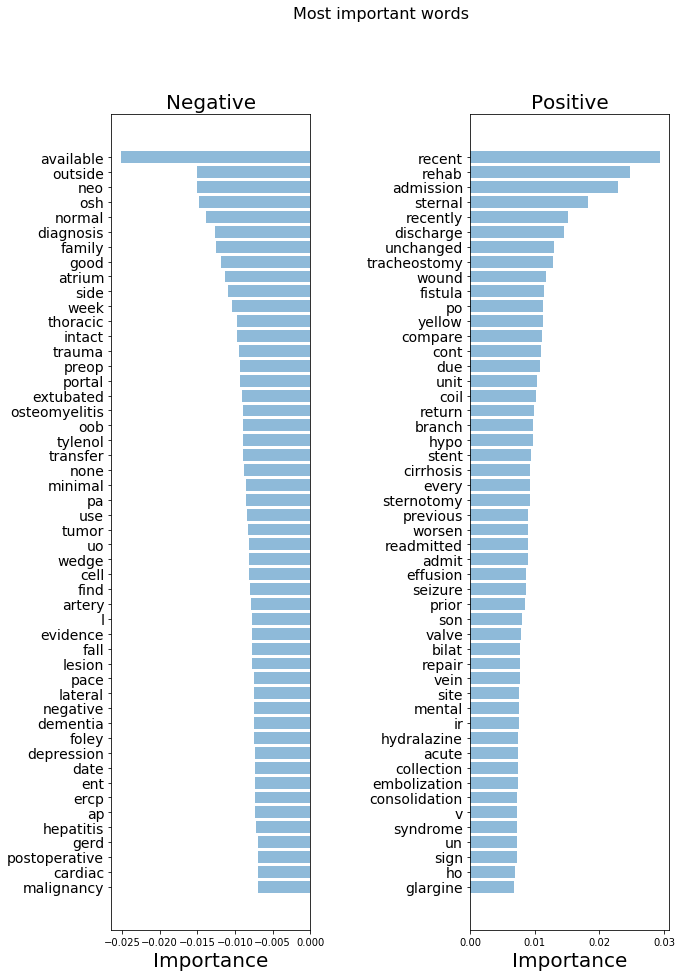

In [137]:
importance = get_most_important_features(vect, clf, 50)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

This looks okay, let's move forward.

# Step 4: Calculate Performance Metrics
To assess the quality of the model we need to measure how well our model performed. In this project I'll choose the the AUROC metric because:
1. For benchmarking purposes &mdash; it is the metric used in the original [Arxiv](https://arxiv.org/pdf/1801.07860.pdf) paper that inspired this project. 
2. It balances False Positive Rates and True Positive Rate. See below for more details:

The **ROC curve** shows how the **recall** vs **precision** relationship changes as we vary the threshold for identifying a positive in our model.

An ROC curve plots the true positive rate on the y-axis versus the false positive rate on the x-axis. The **true positive rate (TPR)** is the **recall** and the **false positive rate (FPR)** is the **probability of a false alarm**. Both of these can be calculated from the confusion matrix:
<img src="images/confusion_matrix.png" width="400" />

<img src="images/true_pos_false_pos.png" width="800" />

[[Source](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)]

* **Recall** expresses the ability of a model to find all the relevant cases within a dataset.
* **Precision** expresses the ability of a classification model to identify only the relevant data points. In other words, the proportion of the data points our model says was relevant actually were relevant. 

<img src="images/recall_precision.png" width="700" />

**NOTE**: Although accuracy is the most common performance metric, it is not the best metric to use in this project because, for example, if you always predict that people will not be hospitalized you might achieve an extremely high accuracy, but **you will not predict any of the actual hospitalizations**.

In [155]:
def calc_recall(y_actual, y_pred, thresh):
    '''Calculates the recall.
        Params:
            y_actual (pandas Series of integers): output labels
            y_pred (numpy array of floats): probability of readmission
            thresh (float): What probabilities are assigned as predicted pos vs neg
        Returns:
            recall (float): recall metric
    '''
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_actual)

In [156]:
def calc_precision(y_actual, y_pred, thresh):
    '''Calculates the precision.
        Params:
            y_actual (pandas Series of integers): output labels
            y_pred (numpy array of floats): probability of readmission
            thresh (float): What probabilities are assigned as predicted pos vs neg
        Returns:
            precision (float): precision metric
    '''
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_pred > thresh)

In [157]:
def calc_prevalence(y_actual):
    '''Calculates the prevalence.
        Params:
            y_actual (pandas Series of integers): output labels
        Returns:
            Prevalence (float): prevalence metric
    '''
    return sum((y_actual == 1)) / len(y_actual)

Set threshold to 0.5 then print performance metrics

In [163]:
thresh = 0.5

train_recall = calc_recall(y_train, y_train_preds, thresh)
valid_recall = calc_recall(y_valid, y_valid_preds, thresh)

train_precision = calc_precision(y_train, y_train_preds, thresh)
valid_precision = calc_precision(y_valid, y_valid_preds, thresh)

train_prevalence = calc_prevalence(y_train)
valid_prevalence = calc_prevalence(y_valid)

print('Train recall:%.3f'%train_recall)
print('Valid recall:%.3f'%valid_recall)

print('Train precision:%.3f'%train_precision)
print('Valid precision:%.3f'%valid_precision)

print('Train prevalence:%.3f'%train_prevalence)
print('Valid prevalence:%.3f'%valid_prevalence)

Train recall:0.948
Valid recall:0.843
Train precision:0.779
Valid precision:0.122
Train prevalence:0.500
Valid prevalence:0.062


Plot the Receiver Operating Characteristic Curve

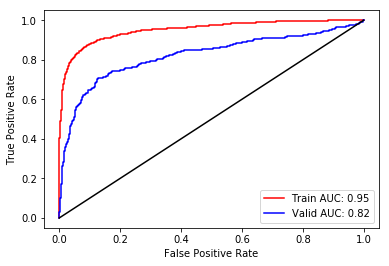

In [161]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Notice that I do have some overfitting. 

Calculate the Area Under the Curve (AUC) for training and validation sets. A well performing classifier has a _low_ classification error but a _high_ AUC [[Source](https://www.researchgate.net/profile/David_Tax/publication/221275639_Learning_Curves_for_the_Analysis_of_Multiple_Instance_Classifiers/links/0fcfd5138ac2f3257b000000.pdf#page=8)].

In [162]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

Train AUC:0.952
Valid AUC:0.822


Quickly throw metrics into a  table format. It's easier to eyeball it for a side-by-side comparison.

In [170]:
df_perf_metrics = pd.DataFrame([
    [train_prevalence, valid_prevalence],
    [train_recall, valid_recall], 
    [train_precision, valid_precision],
    [auc_train, auc_valid]], columns=['Training', 'Validation'])

df_perf_metrics.rename(index={0:'Prevalence', 1:'Recall', 2:'Precision', 3:'AUC'}, 
                 inplace=True)

df_perf_metrics.round(3)

,Training,Validation
Prevalence,0.500,0.062
Recall,0.948,0.843
Precision,0.779,0.122
AUC,0.952,0.822


Notice that there is a significant drop in the precision of the training data versus the validation data. This is because earlier on I balanced the training set by setting the prevalence to 50%, however, the validation remained the original distribution.

## Evaluating Classifier Performance

When you've finally reached the point where you're thinking of ways to improve the model, we can do it in a data-driven way to avoid spending a lot of time going down the wrong path. 

Check out Andrew Ng's _Deep Learning_ Coursera videos where he discusses high-bias vs. high-variance [[Week 1, videos 2 & 3](https://www.coursera.org/learn/deep-neural-network/lecture/ZhclI/bias-variance)]. 
Additionally, in [week 6, videos 1 & 3](https://www.coursera.org/learn/machine-learning/home/week/6) of Andrew Ng's _Machine Learning_ Course he covers **learning curves**.

A learning curve shows when the continuation of learning has no further effects.

If a learning algorithm is suffering from **high bias (underfitting)**, getting more training data will not (by itself) help much &mdash; notice that the **error** remains high. This is shown in Andrew Ng's [slide](https://www.coursera.org/learn/machine-learning/lecture/Kont7/learning-curves) below:

<img src="images/high_bias_Andrew_Ng.png" width="500" />

We can tell that an algorithm is suffering from **high variance (overfitting)** if there's a "large" gap between the training error curve and the cross-validation error curve. If a learning algorithm is suffering from high variance, getting more training data is likely to help because if you were to extrapolate to the right the two errors start to converge. 

<img src="images/high_variance_Andrew_Ng.png" width="500" />

## Plot the Learning Curve
Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [193]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

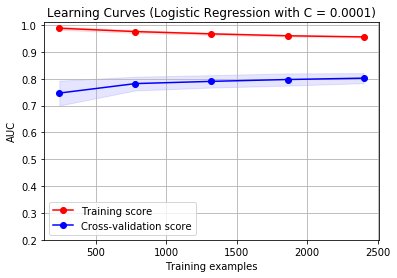

In [195]:
title = "Learning Curves (Logistic Regression with C = 0.0001)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression(C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

As you can see from the learning curve above:
1. There is some overfitting but
2. I am convinced that adding more data will improve the results. This is confirmed by the fact that the cross-validation score trend seems to be increasing as we increase the training examples. It appears that it is trending toward converging w the training score if we were to keep extrapolating. Unfortunately I cannot obtain more data for this project because I'm limited to what the MIMIC-III has made available. So let's move on.

## Hyperparameter Tuning
In general machine learning is a very iterative process where you can tweak hyperparameters to find the optimal results.

Tuning is vital to enhance your models performance. To optimize my hyperparameters I could either fit a [Grid Search](https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/) on my training data or a [Random Search](https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624#76a2) on my training data but I won't perform them because of the lengthy computing time. previously training my model took on average over 12 hours per task (it's lengthy likely due to the fact that I concatenated the notes). Unfortunately due to compute restraints it might take several days to perform hyperparameter tuning. So instead, now I will just discuss the two methods as well as their advantages and disadvantages.

### Grid Search
* Grid search is an approach that methodically builds a and evaluates a model for each combination of algorithm parameters that you will have to define in a grid.
* You can use `sklearn`'s [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* For example with Logistic Regression suppose you define the grid as:
    * penalty = ['l1', 'l2']
    * C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    * It will start with the combination of ['l1', 0.0001], and it will end with ['l2', 1000]. It will go through all intermediate combinations between these two which makes grid search **very computationally expensive**. 


### Random Search
* Random search searches the specified subset of hyperparameters randomly instead of exhaustively. 
* The major benefit, compared to grid search, is its **decreased computation time**.
* The tradeoff however is that we are not guaranteed to find the optimal combination of hyperparameters because it didn't exhaustively search all possible combinations.
* You can use `sklearn's` [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). An important additional parameter to specify here is `n_iter` which is the number of combinations to randomly try. Selecting a number that's too low will decrease our chance of finding he best combination, but selecting a number that's too large will increase compute time. 

## What comes after tuning?
After finding your optimal hyperparmeters you should plug in the hyperparameter values to your **validation set** and keep the best trained model.

Then finally you would run your model on the test set with those same optimal hyperparameters plugged in.

**Side notes:** 
> If your project requires that you take it a step further and compare different models in an unbiased way, you can finally use the test set for this. See more in this Stack Exchange [answer](https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set).

> You cannot use the cross validation set to measure performance of your model accurately, because you will deliberately tune your results to get the best possible metric, over maybe hundreds of variations of your parameters. The cross validation result is therefore likely to be too optimistic. See this Stack Exchange [answer](https://datascience.stackexchange.com/a/18347) as well for more robust explanation.

# Step 6: Run Model on Test set

In [196]:
# Could take some hours
X_test_tf = vect.transform(df_test.TEXT_CONCAT.values.astype(str))

In [197]:
pickle.dump(X_test_tf, open("X_test_tf.pickle", "wb"))

Get the output labels as separate variables

In [198]:
y_test = df_test.OUTPUT_LABEL

Calculate the probability of readmission for each sample with the fitted model

In [199]:
y_test_preds = model.predict_proba(X_test_tf)[:,1]

In [200]:
pickle.dump(y_test_preds, open("y_test_preds.pickle", "wb"))

Print performance metrics

In [205]:
test_recall = calc_recall(y_test, y_test_preds, thresh)
test_precision = calc_precision(y_test, y_test_preds, thresh)
test_prevalence = calc_prevalence(y_test)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train), train_prevalence))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid), valid_prevalence))
print('Test prevalence(n = %d): %.3f'%(len(y_test), test_prevalence))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Valid AUC:%.3f'%auc_test)

print('Train recall:%.3f'%train_recall)
print('Valid recall:%.3f'%valid_recall)
print('Test recall:%.3f'%test_recall)

print('Train precision:%.3f'%train_precision)
print('Valid precision:%.3f'%valid_precision)
print('Test precision:%.3f'%test_precision)

Train prevalence(n = 3000): 0.500
Valid prevalence(n = 3456): 0.062
Test prevalence(n = 3456): 0.065
Train AUC:0.952
Valid AUC:0.822
Valid AUC:0.833
Train recall:0.948
Valid recall:0.843
Test recall:0.852
Train precision:0.779
Valid precision:0.122
Test precision:0.127


Plot the Receiver Operating Characteristic Curve

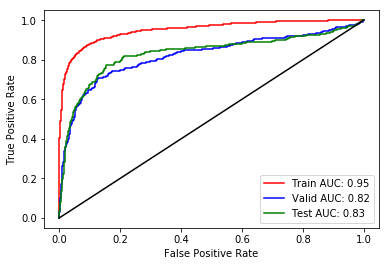

In [203]:
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Quickly throw metrics into a table format. It's easier to eyeball it for a side-by-side comparison.

In [204]:
df_test_perf_metrics = pd.DataFrame([
    [train_prevalence, valid_prevalence, test_prevalence],
    [train_recall, valid_recall, test_recall], 
    [train_precision, valid_precision, test_precision],
    [auc_train, auc_valid, auc_test]], columns=['Training', 'Validation', 'Test'])

df_test_perf_metrics.rename(index={0:'Prevalence', 1:'Recall', 2:'Precision', 3:'AUC'}, 
                 inplace=True)

df_test_perf_metrics.round(3)

,Training,Validation,Test
Prevalence,0.500,0.062,0.065
Recall,0.948,0.843,0.852
Precision,0.779,0.122,0.127
AUC,0.952,0.822,0.833


# Conclusion &mdash; Benchmark the Results
It's time to compare results. Both me and Andrew Long used conventional machine learning models to predict unplanned, 30-day hospital readmissions. My approach (AUC=0.83) **outperformed** Andrew Long's [results](https://towardsdatascience.com/introduction-to-clinical-natural-language-processing-predicting-hospital-readmission-with-1736d52bc709) (AUC=0.70) by **13%**.

As a quick recap, here's a list of additional things that I did differently:
* Removed all English stopwords from NLTK
* Concatenate all the notes (instead of only using the last discharge summary)
* Performed lemmatization
* Readmission can only be counted once

# Next Steps &mdash; Deep Learning
In part 2 of this project I will apply a Deep Learning transformer model to see if that will further improve my outcome. Stay tuned...